# *Salix nigra* SLR: Genome-wide association of sex
Brian J. Sanderson

Last updated: 25 March 2020

In [1]:
# Libraries used in this notebook (R 3.6.2)

suppressMessages(library(tidyverse))
suppressMessages(library(cowplot))
theme_set(theme_cowplot()); theme_update(plot.title = element_text(hjust = 0.5))

## Association mapping with emmax

This notebook begins with the filtered VCF file, which is the end result of the notebook titled [*Salix nigra* SLR: Variants](https://github.com/BrianSanderson/salix-nigra-slr/blob/master/notebooks/Salix-nigra-SLR-02-Variants.ipynb).

### Convert the filtered SNPs to the appropriate format with plink

Plink doesn't like the name Chr15W, so first I convert that to "Chr15"

```bash
# BASH code

zcat snigra.genotypes.snp.filterPASSED_DPfilter_NoCall.vcf | sed -e 's/Chr15W/Chr15/g' > snigra.snps.toplink.vcf

```

Then generate the tped and tfam files with plink

```bash
# BASH code

plink --vcf snigra.snps.toplink.vcf --output-missing-genotype 0 --recode 12 transpose --out snigra --allow-extra-chr
```

Because these are converted from VCFs and not BED files, they don't have sexes associated with them, so I just used VIM to add the correct values for sex for each individual.

### Create the phenotype file

I just used the 1st, 2nd, and 5th columns (representing family ID, personal ID, and sex) to create the phenotype file

```bash
# BASH code

cut -f1,2,5 -d " " snigra.tfam > snigra.pheno
```

### Create the kinship matrix

```bash
# BASH code

emmax-kin-intel64 -v -d 10 snigra
```

### Run the association analysis

```bash
# BASH code

emmax-intel64 -v -d 10 -t snigra -p snigra.pheno -k snigra.aBN.kinf -o snigra.emmax
```

## Plotting GWAS in R

Read in the genotype matrix and the emmax output

In [2]:
tped <- read_delim("snigra.tped", delim = " ", col_names =F, col_types = cols(.default = "c"))
emmax <- read_delim("snigra.emmax.ps", delim = "\t", col_names =F)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double()
)



Because the SNPs don't have names in the VCF, the emmax output doesn't actually have any useful identifiers for which loci are which, but thankfully they're still in the same order as in the original genotype matrix. So we can just bind the chromosome name and position from the genotype matrix to the emmax output.

In [3]:
emmax_annot <- select(tped, X1, X4) %>% 
    bind_cols(., emmax) %>% 
    rename(., chr = X1, pos = X4, SNP_name = X11, Beta = X2, SE_Beta = X3, P_value = X41)

Calculate a bonferonni adjusted P-value and the -log<sub>10</sub> P-value for plotting, and change the data type of the chromosome position to numeric

In [4]:
emmax_annot <- mutate(emmax_annot, P_adj = p.adjust(P_value, method = "bonferroni", n = 2011511),
                                   log10P = -log10(P_value),
                                   pos = as.numeric(pos))

Calculate threshold for significance

In [5]:
-log10(0.05 / (nrow(emmax_annot) * 2))

[1] 7.905582

Make a new data frame that includes cumulatively increasing BP values along the x-axis

In [6]:
emmax_annot <- emmax_annot %>%
  # Change the names of all of the scaffold chromosomes to "SC"
  mutate(., chr = replace(chr, str_detect(chr, "scaffold"), "SC")) %>%
  
  # Refactor the names of chromosomes so they're in order
  mutate(., chr = factor(chr, levels = c("1", "2", "3", "4", "5", "6",
                                         "7", "8", "9", "10", "11", "12", 
                                         "13", "14", "15", "16", "17", "18", 
                                         "19", "SC")))
to_plot <- emmax_annot %>% 
  # Compute chromosome size
  group_by(chr) %>% 
  summarise(chr_len=max(pos)) %>% 
  
  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%
  
  # Add this info to the initial dataset
  left_join(emmax_annot, ., by=c("chr"="chr")) %>%
  
  # Add a cumulative position of each SNP
  arrange(chr, pos) %>%
  mutate( BPcum=pos+tot)

Create a convenience data frame that contains the center of each of the chromosomes for plotting the axis labels. Because we've broken the scaffold names, just make that value the largest value of the cumulative BP variable

In [7]:
axisdf <- to_plot %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )
axisdf <- mutate(axisdf, center = replace(center, chr == "SC", max(to_plot$BPcum, na.rm = T)))

Generate ggplot object

In [8]:
ggplot(to_plot, aes(x=BPcum, y=log10P)) +
    geom_point( aes(color= chr), alpha=0.8, size=1.3) +
    geom_line(aes(y = -log10(0.05 / (nrow(to_plot) * 2))), col = "red4", lty = 5) +
    scale_color_manual(values = rep(c("black", "darkgray"), 20)) + 
    scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
    scale_y_continuous(breaks = c(0, 2.5, 5, 7.5, 10, 12.5), label = c(0, 2.5, 5, 7.5, 10, 12.5)) +
    xlab("Chromosome") + 
    ylab(expression(paste("-log"[10], " P-value")))+
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank(),
      axis.title.x = element_text(size=14), 
      axis.title.y = element_text(size=14), 
      axis.text.y = element_text(size=8),
      axis.text.x = element_text(size=8) 
    ) -> gwas_plot

Specify options for plotting in Jupyter, and display the ggplot object

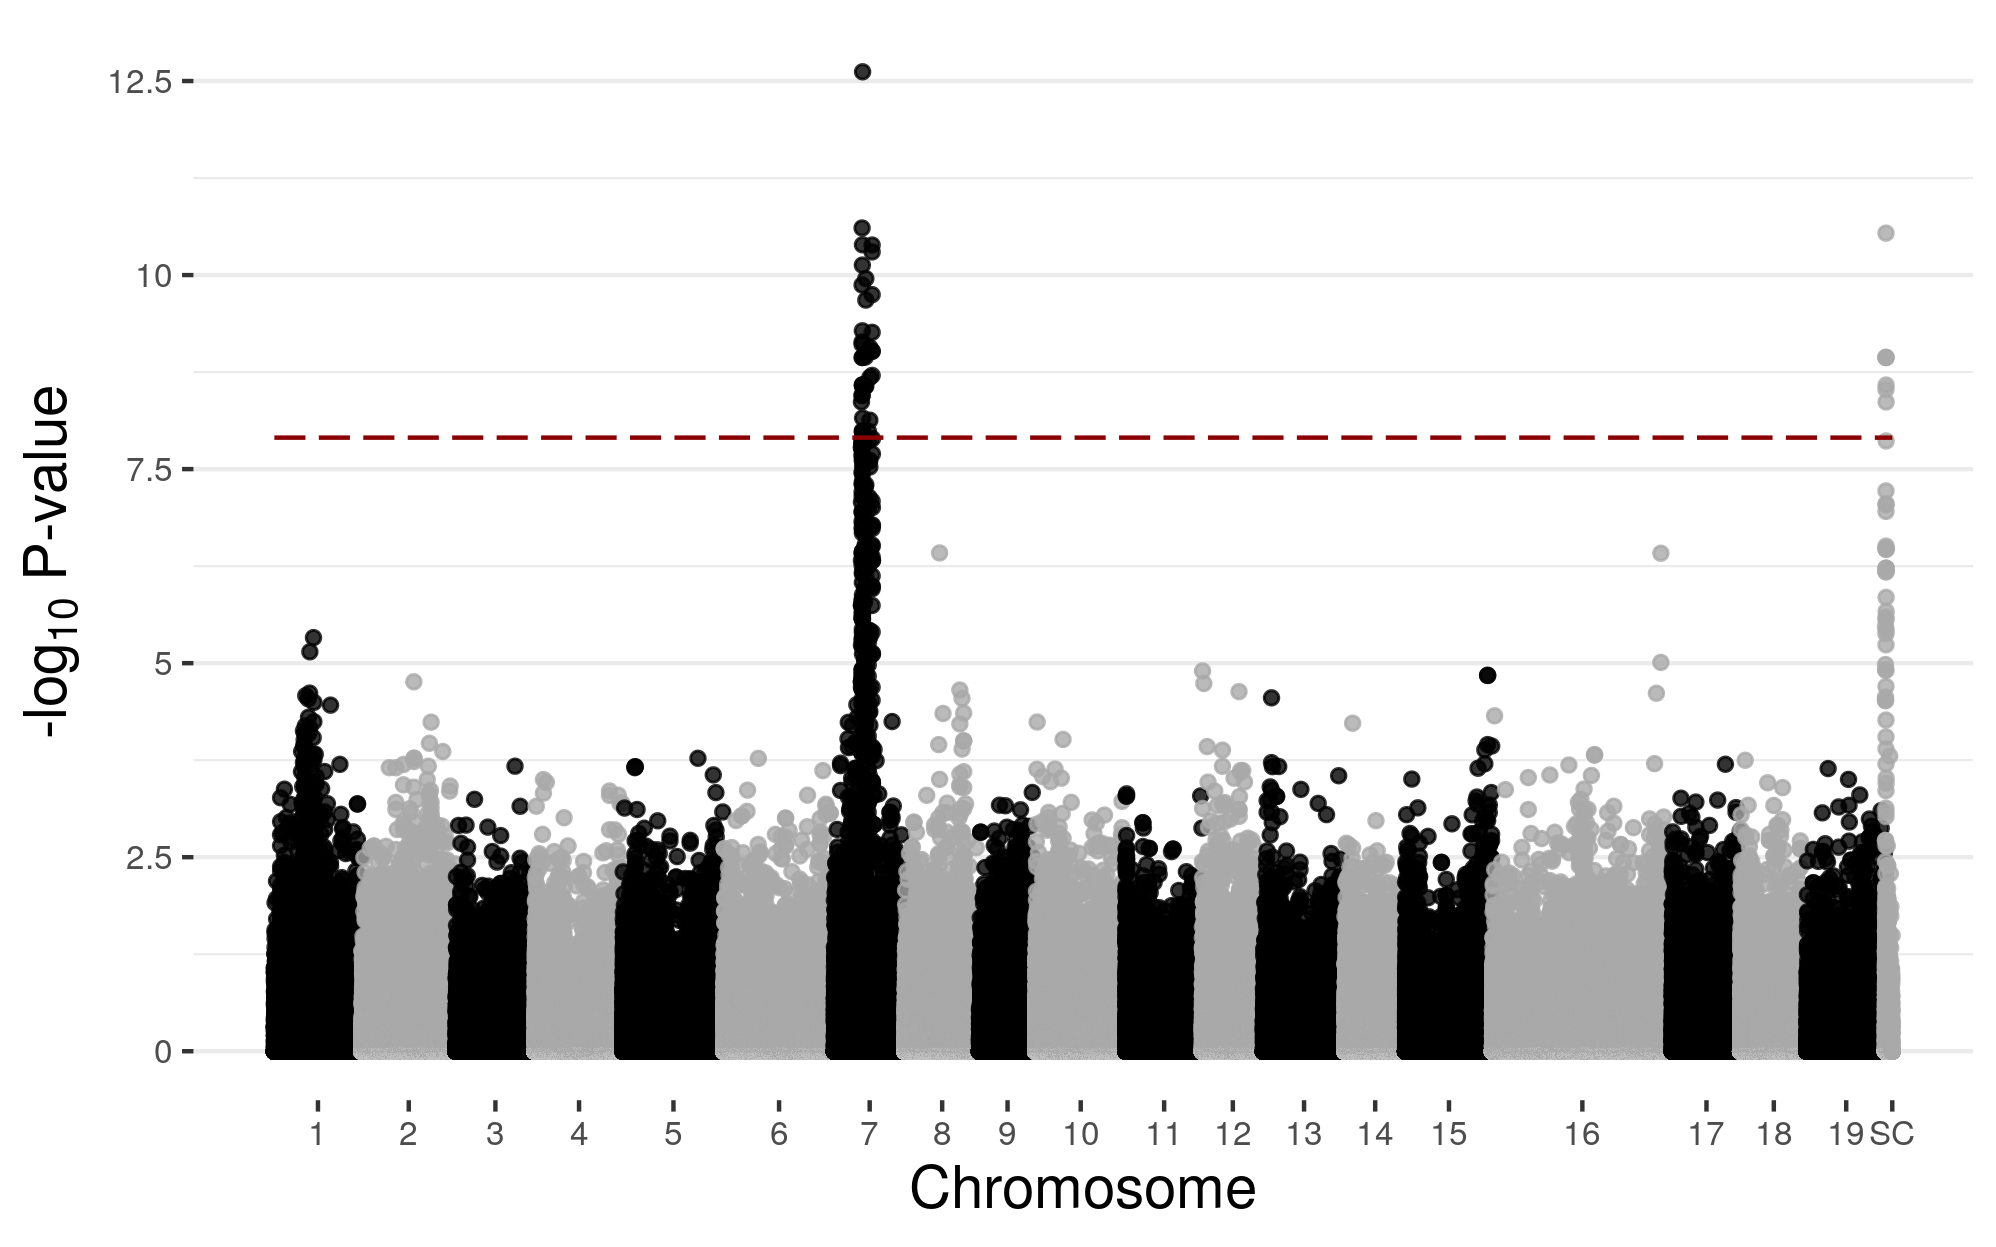

In [9]:
options(repr.plot.width = 6.65354, repr.plot.height = 4.1584625, repr.plot.res = 300)
gwas_plot

## Quantify heterozygosity for males and females at sites with significant sex association

Write out a file ```include_coords.txt``` that has the chromosomes and positions of interest

In [10]:
filter(emmax_annot, log10P > -log10(0.05 / (nrow(emmax_annot) * 2))) %>% 
  select(., chr, pos) %>% 
  mutate(., chr = as.character(chr),
            chr = replace(chr, chr == "7", "Chr07"),
            chr = replace(chr, chr == "SC" & pos < 93000, "scaffold_197"),
            chr = replace(chr, chr == "SC" & pos > 93000, "scaffold_257")) %>%
  filter(., chr == "Chr07") %>%
write_delim(., "include_coords.txt", delim = "\t")

Use the program VCFtools to write out 012 matrices of genotypes for males and females for those sites using the files ```males.txt``` and ```females.txt``` which are just lists of the names of the male and female individuals

```bash
# BASH code

vcftools --gzvcf snigra.filtered.snps.vcf.gz \
         --positions include_coords.txt \
         --keep males.txt \
         --012 \
         --out snigra.males

vcftools --gzvcf snigra.filtered.snps.vcf.gz \
         --positions include_coords.txt \
         --keep females.txt \
         --012 \
         --out snigra.females

```

Read in the 012 matrices and individual name files to quantify heterozygosity

Males:

In [11]:
male_genos <- read_delim("snigra.males.012", col_names = F, delim = "\t") %>%
  select(., -X1) %>%
  mutate(num_hom = rowSums(. == 0) + rowSums(. == 2),
         num_het = rowSums(. == 1),
         num_miss = rowSums(. == -1)) %>% 
  select(., num_hom, num_het, num_miss) %>%
  bind_cols(., read_delim("snigra.males.012.indv", 
                       col_names = "plant_ID", delim = "\t")) %>%
  mutate(., sex = rep("M", 24)) %>%
  select(., plant_ID, sex, num_hom, num_het, num_miss)

Parsed with column specification:
cols(
  .default = col_double()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  plant_ID = col_character()
)



Females:

In [12]:
female_genos <- read_delim("snigra.females.012", col_names = F, delim = "\t") %>%
  select(., -X1) %>%
  mutate(num_hom = rowSums(. == 0) + rowSums(. == 2),
         num_het = rowSums(. == 1),
         num_miss = rowSums(. == -1)) %>% 
  select(., num_hom, num_het, num_miss) %>%
  bind_cols(., read_delim("snigra.females.012.indv", 
                       col_names = "plant_ID", delim = "\t")) %>%
  mutate(., sex = rep("F", 24)) %>%
  select(., plant_ID, sex, num_hom, num_het, num_miss)

Parsed with column specification:
cols(
  .default = col_double()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  plant_ID = col_character()
)



Print a table of heterozygosity for males and females

In [13]:
bind_rows(male_genos, female_genos) %>% print(., n = 48)

# A tibble: 48 x 5
   plant_ID sex   num_hom num_het num_miss
   <chr>    <chr>   <dbl>   <dbl>    <dbl>
 1 SN503M   M           1      36        0
 2 SN507M   M           0      31        6
 3 SN515M   M           0      37        0
 4 SN516M   M          26      11        0
 5 SN517M   M           1      34        2
 6 SN518M   M          12      23        2
 7 SN519M   M           0      37        0
 8 SN520M   M           0      37        0
 9 SN524M   M           1      35        1
10 SN526M   M          12      23        2
11 SN527M   M           0      34        3
12 SN528M   M          15      21        1
13 SN529M   M           3      33        1
14 SN530M   M           0      35        2
15 SN537M   M           0      31        6
16 SN538M   M           0      31        6
17 SN542M   M           0      37        0
18 SN544M   M          22      12        3
19 SN545M   M           0      37        0
20 SN547M   M           0      36        1
21 SN548M   M           0      37  

In [14]:
bind_rows(male_genos, female_genos) %>% mutate(., total = num_hom + num_het) %>%
group_by(sex) %>%
summarize(., mean_het = mean(num_het / total),
             sd_het = sd(num_het / total))

sex,mean_het,sd_het
<chr>,<dbl>,<dbl>
F,0.07157779,0.1477621
M,0.87540497,0.2182776
